In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!pip install -q tensorflow-ranking

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install pydot

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [1]:
import tensorflow_ranking as tfr
import pandas as pd
import numpy as np
from itertools import combinations
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.nn import leaky_relu
from tensorflow.keras.utils import plot_model

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('data/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('data/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.values
rate_test = ratings_test.values

# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

In [3]:
ratings_base.head(2)

,user_id,movie_id,rating,unix_timestamp
0,0,0,5,874965758
1,0,1,3,876893171


In [4]:
ratings_test.head(2)

,user_id,movie_id,rating,unix_timestamp
0,0,19,4,887431883
1,0,32,4,878542699


In [3]:
i_cols = ['movie_id', 'movie_title' ,'release_date','video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children_s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

items.drop(['video_release_date', 'movie_title', 'release_date', 'IMDb_URL'], axis=1,inplace=True)

items['movie_id'] = items['movie_id'] - 1

n_items = items.shape[0]
print('Number of items:', n_items)
items.head()

Number of items: 1682


,movie_id,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [5]:
train = ratings_base.merge(items, how='inner', left_on='movie_id', right_on='movie_id')
test = ratings_test.merge(items, how='inner', left_on='movie_id', right_on='movie_id')
display(train.head(2))
display(test.head(2))

,user_id,movie_id,rating,unix_timestamp,unknown,Action,Adventure,Animation,Children_s,Comedy,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,0,0,5,874965758,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,4,888550871,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


,user_id,movie_id,rating,unix_timestamp,unknown,Action,Adventure,Animation,Children_s,Comedy,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,0,19,4,887431883,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,62,19,3,875748004,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Making train set, test set for models

In [6]:
train = train.sort_values(by=['user_id'], ascending=True)
test = test.sort_values(by=['user_id'], ascending=True)
group_train = list(train.groupby('user_id')['user_id'].count().values)
group_test = list(test.groupby('user_id')['user_id'].count().values)
X_train = train.drop(columns=['user_id', 'movie_id', 'rating', 'unix_timestamp']).values
y_train = train['rating'].values
X_test = test.drop(columns=['user_id', 'movie_id', 'rating', 'unix_timestamp']).values
y_test = test['rating'].values

## Compute NDCG

In [8]:
def evaluate(model, x_test, group_test, y_test):
    metric1 = tfr.keras.metrics.NDCGMetric(topn=1, ragged=True)
    metric2 = tfr.keras.metrics.NDCGMetric(topn=5, ragged=True)
    metric3 = tfr.keras.metrics.NDCGMetric(topn=10, ragged=True)
    if hasattr(model, 'compute_score'):
        y_pred = tf.squeeze(model.compute_score(x_test))
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.RaggedTensor.from_row_lengths(y_pred, group_test)
        y_test = tf.convert_to_tensor(y_test)
        y_test = tf.RaggedTensor.from_row_lengths(y_test, group_test)
    else:
        y_pred = model.predict(x_test, group_test)
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.RaggedTensor.from_row_lengths(y_pred, group_test)
        y_test = tf.convert_to_tensor(y_test)
        y_test = tf.RaggedTensor.from_row_lengths(y_test, group_test)
    s1 = metric1(y_test, y_pred).numpy()
    s2 = metric2(y_test, y_pred).numpy()
    s3 = metric3(y_test, y_pred).numpy()
    print(f"NDCG@1: {s1:.4f}")
    print(f"NDCG@5: {s2:.4f}")
    print(f"NDCG@10: {s3:.4f}")
    return s1, s2, s3

# RankNet

## Making train set for RankNet

In [9]:
# Tao cac cap san pham
xi = []  # San pham 1
xj = []  # San pham 2
pij = []  # So sanh giua sp 1 va sp 2, 0.5 neu danh gia bang nhau, 1 neu danh gia cua i > j, va 0 neu danh gia cua i < j
pair_id = []    # Danh sach cac cap

for user in train['user_id'].unique():
    if len(train[train['user_id']==user]) > 1: 
        # Danh sach cac san pham da tuong tac voi user
        query = train[train['user_id']==user]['movie_id'].values
        query_idx = np.array([*range(len(query))])
        # Cac dac trung cua nhung san pham nay
        doc_features = train[train['movie_id'].isin(query)].drop(columns=['user_id', 'movie_id', 'unix_timestamp', 'rating']).values
        # Danh gia tuong ung cua tung san pham nay
        doc_scores = train[train['user_id']==user]['rating'].values

        for pair_idx in combinations(query_idx, 2):
            pair_id.append(pair_idx)
            i = pair_idx[0]
            j = pair_idx[1]
            xi.append(doc_features[i])
            xj.append(doc_features[j])
            if doc_scores[i] == doc_scores[j]:
                _pij = 0.5
            elif doc_scores[i] > doc_scores[j]:
                _pij = 1
            else: 
                _pij = 0
            pij.append(_pij)

xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)

## RankNet architecture

In [10]:
class RankNet(keras.Model):
    def __init__(self, hidden_dim1 = 16, hidden_dim2=8):
        super().__init__()
        self.dense  = keras.Sequential([
            keras.layers.Dense(hidden_dim1, activation=leaky_relu),
            keras.layers.Dense(hidden_dim2, activation=leaky_relu)
        ])
        self.o = keras.layers.Dense(1, activation='linear')
        self.oi_minus_oj = keras.layers.Subtract()
        self.sigmoid = keras.layers.Activation('sigmoid')
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense(xi)
        densej = self.dense(xj)
        oi = self.o(densei)
        oj = self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = self.sigmoid(oij)
        return output
    def build_graph(self):
        x = [keras.Input(shape=(10)), keras.Input(shape=(10))]
        return keras.Model(inputs=x, outputs=self.call(x))
    def compute_score(self, inputs):
        try:
            self.tranable = False
            dense = self.dense(inputs)
            o = self.o(dense)
            return o
        finally:
            self.trainable = True

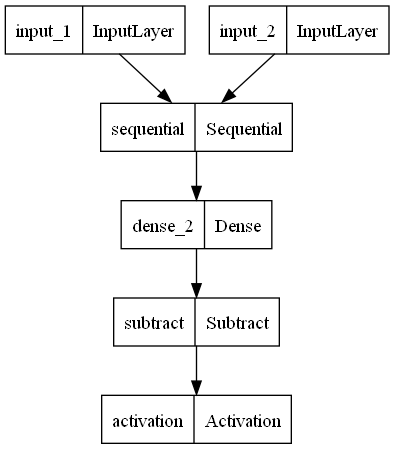

In [11]:
# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

In [12]:
inputs = tf.data.Dataset.from_tensor_slices((xi, xj))
target = tf.data.Dataset.from_tensor_slices(pij)
train_dataset = tf.data.Dataset.zip((inputs, target))

In [13]:
train_dataset = train_dataset.batch(512)

In [14]:
# train model using compile and fit
ranknet = RankNet()
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'ranknet_checkpoints/ranknet.h5',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)
ranknet.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=[
                    tfr.keras.metrics.NDCGMetric(topn=1), 
                    tfr.keras.metrics.NDCGMetric(topn=5),
                    tfr.keras.metrics.NDCGMetric(topn=10)],
                )
# history = ranknet.fit([xi, xj], pij, epochs=50, batch_size=512, callbacks=[earlystopping, model_checkpoint])
history = ranknet.fit(x=train_dataset, epochs=50, callbacks=[earlystopping, model_checkpoint])

Epoch 1/50
17778/17778 [==============================] - 24s 1ms/step - loss: 0.6930 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 2/50
17778/17778 [==============================] - 24s 1ms/step - loss: 0.6929 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 3/50
17778/17778 [==============================] - 22s 1ms/step - loss: 0.6929 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 4/50
17778/17778 [==============================] - 21s 1ms/step - loss: 0.6928 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 5/50
17778/17778 [==============================] - 21s 1ms/step - loss: 0.6928 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 6/50
17778/17778 [==============================] - 21s 1ms/step - loss: 0.6926 - ndcg_metric: 0.6510 - ndcg_metric_1: 0.6510 - ndcg_metric_2: 0.6510
Epoch 7/50
17778/17778 [==============================] - 23s 1m

In [15]:
evaluate(ranknet, X_test, group_test, y_test)

NDCG@1: 0.5030
NDCG@5: 0.6339
NDCG@10: 0.8135


(0.5029891, 0.6339169, 0.8134613)

# LambdaRANK with lightgbm

In [16]:
import lightgbm as lgb

gbm = lgb.LGBMRanker(early_stopping_rounds=20, verbose=1)

gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_test, y_test)], eval_group=[group_test],
        eval_at=[1,5,10])

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 90570, number of used features: 18
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's ndcg@1: 0.666875	valid_0's ndcg@5: 0.72672	valid_0's ndcg@10: 0.865298


LGBMRanker(early_stopping_rounds=20, verbose=1)

In [17]:
evaluate(gbm, X_test, group_test, y_test)

NDCG@1: 0.6742
NDCG@5: 0.7272
NDCG@10: 0.8650


(0.6742281, 0.7272175, 0.8649508)

In [20]:
import pickle
with open('lightgbm_checkpoints/lightgbm_lambdarank.h5', 'wb') as f:
    pickle.dump(gbm, f)

# LambdaMART with xgboost

## Pairwise lambdaMART

In [22]:
import xgboost
training_params = {'max_depth': 5, 'max_leaves': 10, 'objective': 'rank:pairwise', 'n_estimators':100}
xgboost_lambdamart_pairwise = xgboost.XGBRanker(**training_params)
xgboost_lambdamart_pairwise.fit(
    X_train, y_train, group_train, verbose=True, eval_set=[(X_test, y_test)], 
    eval_group=[group_test], eval_metric = ['ndcg@1', 'ndcg@5', 'ndcg@10'],
)

[0]	validation_0-ndcg@1:0.61646	validation_0-ndcg@5:0.70004	validation_0-ndcg@10:0.84900
[1]	validation_0-ndcg@1:0.62148	validation_0-ndcg@5:0.70276	validation_0-ndcg@10:0.85137
[2]	validation_0-ndcg@1:0.62066	validation_0-ndcg@5:0.70713	validation_0-ndcg@10:0.85264
[3]	validation_0-ndcg@1:0.62068	validation_0-ndcg@5:0.70526	validation_0-ndcg@10:0.85222
[4]	validation_0-ndcg@1:0.62495	validation_0-ndcg@5:0.70659	validation_0-ndcg@10:0.85325
[5]	validation_0-ndcg@1:0.62747	validation_0-ndcg@5:0.70899	validation_0-ndcg@10:0.85410
[6]	validation_0-ndcg@1:0.63482	validation_0-ndcg@5:0.71235	validation_0-ndcg@10:0.85597
[7]	validation_0-ndcg@1:0.63154	validation_0-ndcg@5:0.71142	validation_0-ndcg@10:0.85559
[8]	validation_0-ndcg@1:0.63443	validation_0-ndcg@5:0.71255	validation_0-ndcg@10:0.85622
[9]	validation_0-ndcg@1:0.63468	validation_0-ndcg@5:0.71458	validation_0-ndcg@10:0.85694
[10]	validation_0-ndcg@1:0.63662	validation_0-ndcg@5:0.71526	validation_0-ndcg@10:0.85726
[11]	validation_0-nd

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
          max_leaves=10, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=100,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [23]:
evaluate(xgboost_lambdamart_pairwise, X_test, group_test, y_test)

NDCG@1: 0.6531
NDCG@5: 0.7234
NDCG@10: 0.8622


(0.65306866, 0.7233621, 0.8622396)

In [26]:
import pickle
with open('xgboost_checkpoints/xgboost_lambdamart_pairwise.h5', 'wb') as f:
    pickle.dump(xgboost_lambdamart_pairwise, f)

## Listwise lambdaMART

In [24]:
import xgboost
training_params = {'max_depth': 5, 
                   'max_leaves': 10, 
                   'objective': 'rank:ndcg',   # phương pháp Listwise và tối đa hóa NDCG; hoặc "rank:map" để tối đa hóa MAP
                   'n_estimators':100}
xgboost_lambdamart_listwise = xgboost.XGBRanker(**training_params)
xgboost_lambdamart_listwise.fit(
    X_train, y_train, group_train, verbose=True, eval_set=[(X_test, y_test)], 
    eval_group=[group_test], eval_metric = ['ndcg@1', 'ndcg@5', 'ndcg@10'],
)

[0]	validation_0-ndcg@1:0.62113	validation_0-ndcg@5:0.70299	validation_0-ndcg@10:0.85052
[1]	validation_0-ndcg@1:0.62451	validation_0-ndcg@5:0.70473	validation_0-ndcg@10:0.85176
[2]	validation_0-ndcg@1:0.62518	validation_0-ndcg@5:0.70415	validation_0-ndcg@10:0.85185
[3]	validation_0-ndcg@1:0.62518	validation_0-ndcg@5:0.70380	validation_0-ndcg@10:0.85198
[4]	validation_0-ndcg@1:0.62289	validation_0-ndcg@5:0.70327	validation_0-ndcg@10:0.85158
[5]	validation_0-ndcg@1:0.62443	validation_0-ndcg@5:0.70638	validation_0-ndcg@10:0.85285
[6]	validation_0-ndcg@1:0.62779	validation_0-ndcg@5:0.70672	validation_0-ndcg@10:0.85325
[7]	validation_0-ndcg@1:0.62658	validation_0-ndcg@5:0.70895	validation_0-ndcg@10:0.85394
[8]	validation_0-ndcg@1:0.62713	validation_0-ndcg@5:0.70963	validation_0-ndcg@10:0.85419
[9]	validation_0-ndcg@1:0.62934	validation_0-ndcg@5:0.71024	validation_0-ndcg@10:0.85449
[10]	validation_0-ndcg@1:0.62725	validation_0-ndcg@5:0.71158	validation_0-ndcg@10:0.85458
[11]	validation_0-nd

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
          max_leaves=10, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=100,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [25]:
evaluate(xgboost_lambdamart_listwise, X_test, group_test, y_test)

NDCG@1: 0.6574
NDCG@5: 0.7236
NDCG@10: 0.8626


(0.65744275, 0.7235935, 0.8626191)

In [27]:
import pickle
with open('xgboost_checkpoints/xgboost_lambdamart_listwise.h5', 'wb') as f:
    pickle.dump(xgboost_lambdamart_listwise, f)